In [34]:
import os
import pandas as pd
from copy import deepcopy
import matplotlib.pyplot as plt

from ORBIT import ProjectManager, load_config
from ORBIT.phases.install import MonopileInstallation, JacketInstallation

weather = pd.read_csv("data/example_weather.csv", parse_dates=["datetime"])\
            .set_index("datetime")

In [2]:
fixed_config = load_config("configs/example_fixed_project.yaml")

In [24]:
fixed_config["jacket"] = {
    "diameter": 10,
    "height": 100,
    "length": 100,
    "mass": 100,
    "deck_space": 100,
    "unit_cost": 1e6
}

# fixed_config["feeder"] = "example_feeder"
# fixed_config["num_feeders"] = 2

# fixed_config["transition_piece"] = {
#     "mass": 1000,
#     "deck_space": 1000,
#     "unit_cost": 1e6
# }

# fixed_config["jacket_supply_chain"] = {
#     "enabled": True,
#     "substructure_delivery_time": 100,
#     "num_substructures_delivered": 2,
# }

### Jacket Installation w/ Unlimited Storage at Port

In [32]:
project = JacketInstallation(fixed_config, weather=weather)
project.run()

df = pd.DataFrame(project.env.actions)

print(f"Installation Time: {project.total_phase_time:.0f}h")

Installation Time: 7720h


### Insufficient Substructure Fabrication

In [54]:
config = deepcopy(fixed_config)

config["jacket_supply_chain"] = {
    "enabled": True,
    "substructure_delivery_time": 500,
    "num_substructures_delivered": 2,
}

project = JacketInstallation(config, weather=weather)
project.run()

df = pd.DataFrame(project.env.actions)
print(f"Installation Time: {project.total_phase_time:.0f}h")

# Insufficient fabrication caused a ~5k hour delay

Installation Time: 12981h


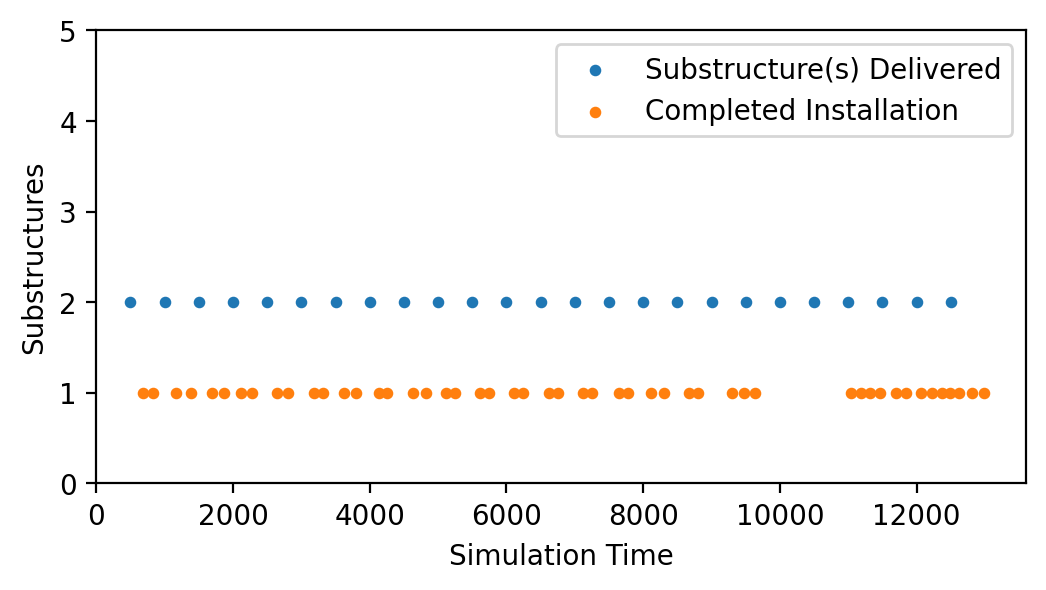

In [40]:
deliveries = df.loc[df['action'].str.contains('Delivered')][['action', 'time']]
deliveries['number'] = deliveries['action'].apply(lambda x: int(x.split(" ")[1]))
# deliveries

installs = df.loc[df['action'].str.contains('Grout Jacket')][['action', 'time']]
installs['number'] = 1

fig = plt.figure(figsize=(6,3), dpi=200)
ax = fig.add_subplot(111)

ax.scatter(deliveries['time'], deliveries['number'], s=10, label="Substructure(s) Delivered")
ax.scatter(installs['time'], installs['number'], s=10, label="Completed Installation")

ax.set_xlim(0, ax.get_xlim()[1])
ax.set_ylim(0, 5)

ax.set_xlabel("Simulation Time")
ax.set_ylabel("Substructures")

ax.legend()

# Note period of bad weather at ~10k hours

In [41]:
installs_neg = installs.copy()
installs_neg["number"] *= -1

total = pd.concat([deliveries, installs_neg]).sort_values('time')
total['storage'] = total['number'].cumsum()
# total

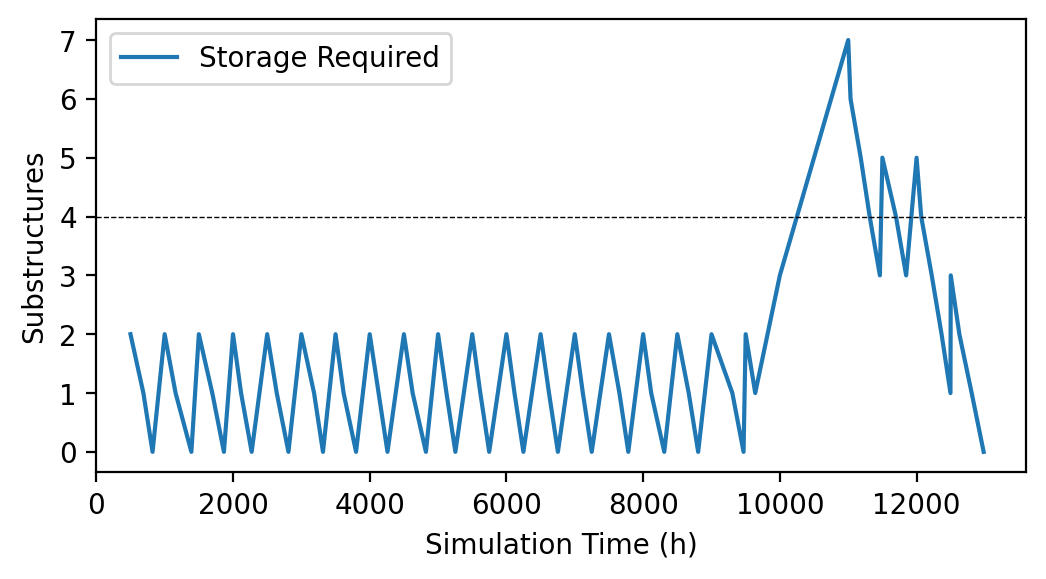

In [43]:
fig = plt.figure(figsize=(6,3), dpi=200)
ax = fig.add_subplot(111)

ax.plot(total['time'], total['storage'], label="Storage Required")

ax.set_xlim(0, ax.get_xlim()[1])
# ax.set_ylim(0, 5)

ax.axhline(4, ls="--", lw=0.5, c='k')

ax.set_xlabel("Simulation Time (h)")
ax.set_ylabel("Substructures")

ax.legend()

### Increased Substructure Fabrication

In [50]:
config = deepcopy(fixed_config)

config["jacket_supply_chain"] = {
    "enabled": True,
    "substructure_delivery_time": 250,
    "num_substructures_delivered": 2,
}

project = JacketInstallation(config, weather=weather)
project.run()

df = pd.DataFrame(project.env.actions)
print(f"Installation Time: {project.total_phase_time:.0f}h")

Installation Time: 7850h


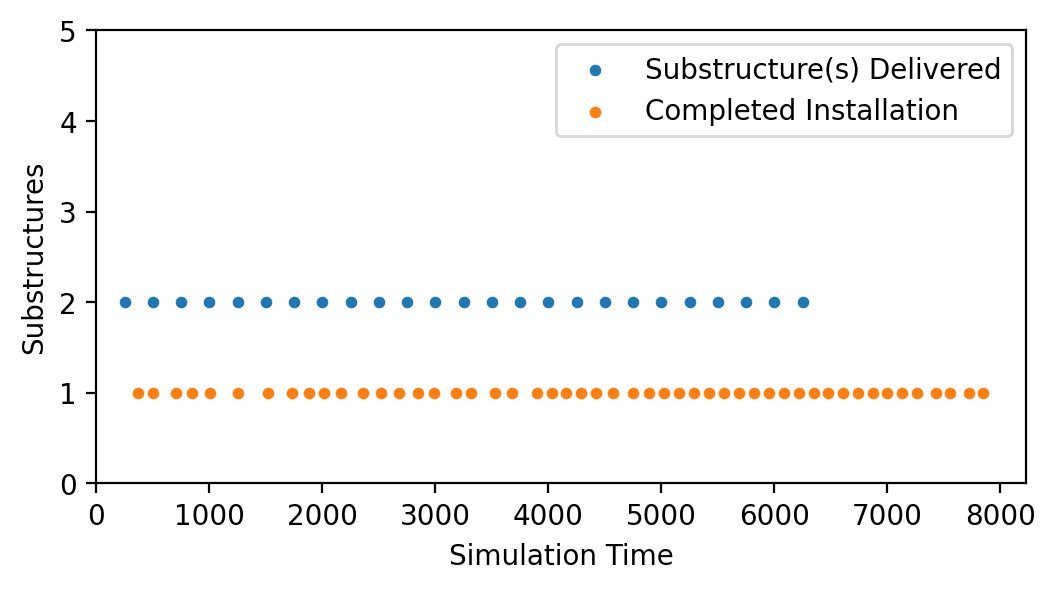

In [51]:
deliveries = df.loc[df['action'].str.contains('Delivered')][['action', 'time']]
deliveries['number'] = deliveries['action'].apply(lambda x: int(x.split(" ")[1]))
# deliveries

installs = df.loc[df['action'].str.contains('Grout Jacket')][['action', 'time']]
installs['number'] = 1

fig = plt.figure(figsize=(6,3), dpi=200)
ax = fig.add_subplot(111)

ax.scatter(deliveries['time'], deliveries['number'], s=10, label="Substructure(s) Delivered")
ax.scatter(installs['time'], installs['number'], s=10, label="Completed Installation")

ax.set_xlim(0, ax.get_xlim()[1])
ax.set_ylim(0, 5)

ax.set_xlabel("Simulation Time")
ax.set_ylabel("Substructures")

ax.legend()

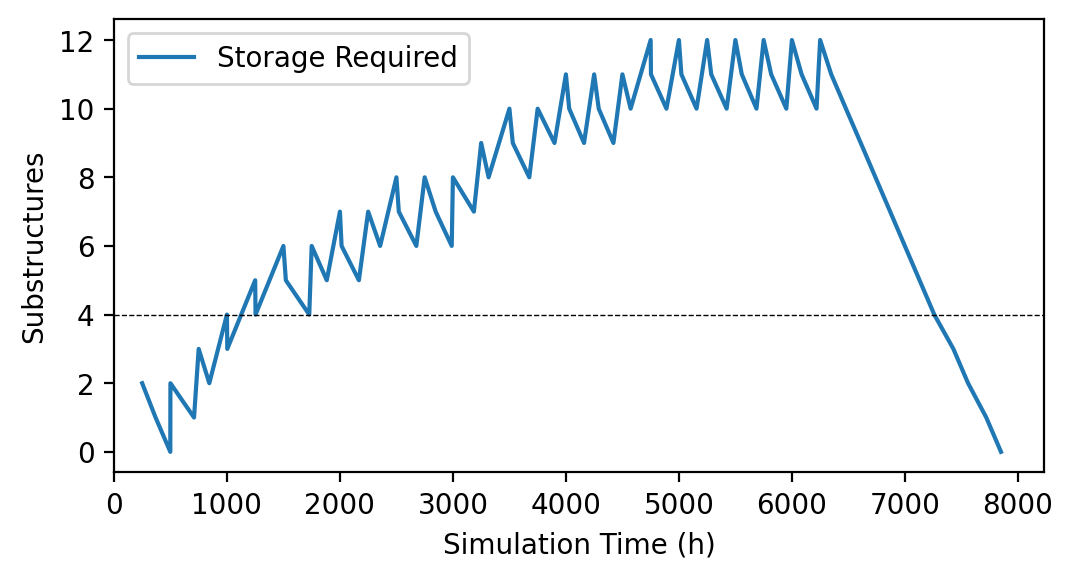

In [52]:
installs_neg = installs.copy()
installs_neg["number"] *= -1

total = pd.concat([deliveries, installs_neg]).sort_values('time')
total['storage'] = total['number'].cumsum()

fig = plt.figure(figsize=(6,3), dpi=200)
ax = fig.add_subplot(111)

ax.plot(total['time'], total['storage'], label="Storage Required")

ax.set_xlim(0, ax.get_xlim()[1])
# ax.set_ylim(0, 5)

ax.axhline(4, ls="--", lw=0.5, c='k')

ax.set_xlabel("Simulation Time (h)")
ax.set_ylabel("Substructures")

ax.legend()

### Questions

- Is this approach and the results valuable to Equinor?
- How to quantify the project cost associated with increased storage required?
  - $/substructure/day

  - $/laydown space/day

- How to quantify the delivery costs associated with substructure delivery?
  - $/substructure

  - $/substructure/km
